# Black-Scholes Baseline and Implied Volatility Analysis

This notebook implements Black-Scholes option pricing as a baseline model and analyzes implied volatility patterns.

## Objectives
1. Implement Black-Scholes option pricing model
2. Calculate theoretical option prices
3. Extract and analyze implied volatilities
4. Build volatility surfaces
5. Compare market prices vs theoretical prices
6. Establish baseline performance metrics

In [29]:


# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import brentq, minimize_scalar
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Prepare Data

In [10]:
# Load data directly from files
data_dir = Path('../data')

# Load equity data
equity_data = pd.read_csv(data_dir / 'raw' / 'equities' / 'combined_equities.csv')
equity_data['Date'] = pd.to_datetime(equity_data['Date'])

# Load treasury data
treasury_data = pd.read_csv(data_dir / 'external' / 'treasury_yields.csv')
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

# Load options data
options_data = pd.read_csv(data_dir / 'raw' / 'options' / 'spy_options.csv')
options_data['Date'] = pd.to_datetime(options_data['Date'])
options_data['Expiration'] = pd.to_datetime(options_data['Expiration'])

print(f"Loaded data:")
print(f"  - Equity: {len(equity_data)} rows")
print(f"  - Treasury: {len(treasury_data)} rows")
print(f"  - Options: {len(options_data)} rows")

# Get SPY data for underlying price
spy_data = equity_data[equity_data['Symbol'] == 'SPY'].copy()
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data = spy_data.sort_values('Date')

print(f"\nSPY data: {len(spy_data)} observations")
print(f"Price range: ${spy_data['Close'].min():.2f} - ${spy_data['Close'].max():.2f}")

Loaded data:
  - Equity: 5220 rows
  - Treasury: 1462 rows
  - Options: 768 rows

SPY data: 1044 observations
Price range: $362.91 - $794.96


In [11]:
# Prepare options data
options_clean = options_data.copy()
options_clean['Date'] = pd.to_datetime(options_clean['Date'])
options_clean['Expiration'] = pd.to_datetime(options_clean['Expiration'])
options_clean['DTE'] = (options_clean['Expiration'] - options_clean['Date']).dt.days
options_clean['Time_to_Expiry'] = options_clean['DTE'] / 365.25

# Filter options with reasonable parameters
options_filtered = options_clean[
    (options_clean['DTE'] >= 7) &  # At least 1 week to expiry
    (options_clean['DTE'] <= 365) &  # At most 1 year
    (options_clean['Bid'] > 0) &  # Positive bid
    (options_clean['Ask'] > options_clean['Bid']) &  # Ask > Bid
    (options_clean['Last'] > 0)  # Positive last price
].copy()

print(f"Filtered options: {len(options_filtered)} contracts")
print(f"DTE range: {options_filtered['DTE'].min()} - {options_filtered['DTE'].max()} days")

Filtered options: 704 contracts
DTE range: 45 - 349 days


In [12]:
# Get risk-free rate from treasury data
# Use 3-month treasury as risk-free rate proxy
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])
treasury_current = treasury_data.iloc[-1]  # Most recent data
risk_free_rate = treasury_current['DGS3MO'] / 100  # Convert percentage to decimal

print(f"Risk-free rate (3M Treasury): {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%)")

# Get current SPY price (use latest close)
current_spy_price = spy_data['Close'].iloc[-1]
print(f"Current SPY price: ${current_spy_price:.2f}")

Risk-free rate (3M Treasury): 0.0089 (0.89%)
Current SPY price: $793.41


## 2. Black-Scholes Implementation

In [13]:
class BlackScholesCalculator:
    """Black-Scholes option pricing calculator"""
    
    @staticmethod
    def d1(S, K, T, r, sigma):
        """Calculate d1 parameter"""
        return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    @staticmethod
    def d2(S, K, T, r, sigma):
        """Calculate d2 parameter"""
        return BlackScholesCalculator.d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    @staticmethod
    def call_price(S, K, T, r, sigma):
        """Calculate European call option price"""
        if T <= 0:
            return max(S - K, 0)
        
        d1_val = BlackScholesCalculator.d1(S, K, T, r, sigma)
        d2_val = BlackScholesCalculator.d2(S, K, T, r, sigma)
        
        price = S * norm.cdf(d1_val) - K * np.exp(-r * T) * norm.cdf(d2_val)
        return max(price, 0)
    
    @staticmethod
    def put_price(S, K, T, r, sigma):
        """Calculate European put option price"""
        if T <= 0:
            return max(K - S, 0)
        
        d1_val = BlackScholesCalculator.d1(S, K, T, r, sigma)
        d2_val = BlackScholesCalculator.d2(S, K, T, r, sigma)
        
        price = K * np.exp(-r * T) * norm.cdf(-d2_val) - S * norm.cdf(-d1_val)
        return max(price, 0)
    
    @staticmethod
    def vega(S, K, T, r, sigma):
        """Calculate option vega (sensitivity to volatility)"""
        if T <= 0:
            return 0
        
        d1_val = BlackScholesCalculator.d1(S, K, T, r, sigma)
        return S * norm.pdf(d1_val) * np.sqrt(T)

print("Black-Scholes calculator implemented!")

Black-Scholes calculator implemented!


In [14]:
# Test Black-Scholes implementation
test_params = {
    'S': 400,    # Current price
    'K': 400,    # Strike price (ATM)
    'T': 0.25,   # 3 months to expiry
    'r': 0.05,   # 5% risk-free rate
    'sigma': 0.20  # 20% volatility
}

call_value = BlackScholesCalculator.call_price(**test_params)
put_value = BlackScholesCalculator.put_price(**test_params)
vega_value = BlackScholesCalculator.vega(**test_params)

print(f"Test Black-Scholes calculation:")
print(f"Parameters: S=${test_params['S']}, K=${test_params['K']}, T={test_params['T']:.2f}y, r={test_params['r']:.2%}, σ={test_params['sigma']:.2%}")
print(f"Call price: ${call_value:.2f}")
print(f"Put price: ${put_value:.2f}")
print(f"Vega: {vega_value:.4f}")

# Verify put-call parity: C - P = S - K*e^(-rT)
parity_check = call_value - put_value - (test_params['S'] - test_params['K'] * np.exp(-test_params['r'] * test_params['T']))
print(f"Put-call parity check (should be ~0): {parity_check:.6f}")

Test Black-Scholes calculation:
Parameters: S=$400, K=$400, T=0.25y, r=5.00%, σ=20.00%
Call price: $18.46
Put price: $13.49
Vega: 78.5760
Put-call parity check (should be ~0): -0.000000


## 3. Implied Volatility Calculation

In [15]:
def implied_volatility(market_price, S, K, T, r, option_type='call', max_iterations=100, tolerance=1e-6):
    """Calculate implied volatility using Brent's method"""
    
    if T <= 0:
        return np.nan
    
    # Intrinsic value
    if option_type.lower() == 'call':
        intrinsic = max(S - K, 0)
    else:
        intrinsic = max(K - S, 0)
    
    # Check if market price is below intrinsic value
    if market_price <= intrinsic:
        return np.nan
    
    def price_difference(sigma):
        if option_type.lower() == 'call':
            theoretical_price = BlackScholesCalculator.call_price(S, K, T, r, sigma)
        else:
            theoretical_price = BlackScholesCalculator.put_price(S, K, T, r, sigma)
        return theoretical_price - market_price
    
    try:
        # Use Brent's method to find implied volatility
        # Search between 1% and 500% volatility
        iv = brentq(price_difference, 0.01, 5.0, xtol=tolerance, maxiter=max_iterations)
        return iv
    except (ValueError, RuntimeError):
        # If Brent's method fails, try optimization
        try:
            result = minimize_scalar(
                lambda sigma: abs(price_difference(sigma)),
                bounds=(0.01, 5.0),
                method='bounded'
            )
            if result.success and abs(price_difference(result.x)) < tolerance:
                return result.x
            else:
                return np.nan
        except:
            return np.nan

print("Implied volatility function implemented!")

Implied volatility function implemented!


In [16]:
# Test implied volatility calculation
test_iv = implied_volatility(
    market_price=call_value,
    S=test_params['S'],
    K=test_params['K'],
    T=test_params['T'],
    r=test_params['r'],
    option_type='call'
)

print(f"Test implied volatility calculation:")
print(f"Input volatility: {test_params['sigma']:.4f}")
print(f"Calculated IV: {test_iv:.4f}")
print(f"Difference: {abs(test_iv - test_params['sigma']):.6f}")

Test implied volatility calculation:
Input volatility: 0.2000
Calculated IV: 0.2000
Difference: 0.000000


## 4. Calculate Theoretical Prices and Implied Volatilities

In [17]:
# Calculate theoretical prices using market IV
print("Calculating theoretical prices and implied volatilities...")

results = []
total_options = len(options_filtered)

for idx, option in options_filtered.iterrows():
    if idx % 100 == 0:
        print(f"Processing option {idx + 1}/{total_options}")
    
    # Use mid price as market price
    market_price = (option['Bid'] + option['Ask']) / 2
    
    # Calculate implied volatility
    iv = implied_volatility(
        market_price=market_price,
        S=current_spy_price,
        K=option['Strike'],
        T=option['Time_to_Expiry'],
        r=risk_free_rate,
        option_type=option['Type']
    )
    
    # Calculate theoretical price using calculated IV
    if not np.isnan(iv):
        if option['Type'] == 'C':
            theoretical_price = BlackScholesCalculator.call_price(
                current_spy_price, option['Strike'], option['Time_to_Expiry'], risk_free_rate, iv
            )
        else:
            theoretical_price = BlackScholesCalculator.put_price(
                current_spy_price, option['Strike'], option['Time_to_Expiry'], risk_free_rate, iv
            )
        
        # Calculate vega
        vega = BlackScholesCalculator.vega(
            current_spy_price, option['Strike'], option['Time_to_Expiry'], risk_free_rate, iv
        )
    else:
        theoretical_price = np.nan
        vega = np.nan
    
    # Calculate moneyness
    moneyness = current_spy_price / option['Strike']
    
    results.append({
        'Strike': option['Strike'],
        'Type': option['Type'],
        'DTE': option['DTE'],
        'Time_to_Expiry': option['Time_to_Expiry'],
        'Market_Price': market_price,
        'Theoretical_Price': theoretical_price,
        'Implied_Vol': iv,
        'Market_IV': option['IV'],  # Original IV from data
        'Vega': vega,
        'Moneyness': moneyness,
        'Volume': option['Volume'],
        'OpenInt': option['OpenInt']
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.dropna(subset=['Implied_Vol', 'Theoretical_Price'])

print(f"\nCompleted calculations for {len(results_df)} options")
print(f"IV calculation success rate: {len(results_df)/len(options_filtered)*100:.1f}%")

Calculating theoretical prices and implied volatilities...
Processing option 1/704
Processing option 101/704
Processing option 201/704
Processing option 301/704
Processing option 401/704
Processing option 501/704
Processing option 601/704
Processing option 701/704

Completed calculations for 704 options
IV calculation success rate: 100.0%


In [18]:
# Display results summary
print("Black-Scholes Analysis Results:")
print("=" * 40)

# Basic statistics
print(f"Options analyzed: {len(results_df)}")
print(f"Calls: {len(results_df[results_df['Type'] == 'C'])}")
print(f"Puts: {len(results_df[results_df['Type'] == 'P'])}")

# Implied volatility statistics
print(f"\nImplied Volatility Statistics:")
print(f"Mean IV: {results_df['Implied_Vol'].mean():.4f} ({results_df['Implied_Vol'].mean()*100:.2f}%)")
print(f"Median IV: {results_df['Implied_Vol'].median():.4f} ({results_df['Implied_Vol'].median()*100:.2f}%)")
print(f"IV Range: {results_df['Implied_Vol'].min():.4f} - {results_df['Implied_Vol'].max():.4f}")

# Price comparison
results_df['Price_Diff'] = results_df['Market_Price'] - results_df['Theoretical_Price']
results_df['Price_Diff_Pct'] = results_df['Price_Diff'] / results_df['Market_Price'] * 100

print(f"\nPrice Comparison (Market vs Theoretical):")
print(f"Mean absolute difference: ${results_df['Price_Diff'].abs().mean():.4f}")
print(f"Mean percentage difference: {results_df['Price_Diff_Pct'].abs().mean():.2f}%")
print(f"RMSE: ${np.sqrt((results_df['Price_Diff']**2).mean()):.4f}")

display(results_df.head(10))

Black-Scholes Analysis Results:
Options analyzed: 704
Calls: 352
Puts: 352

Implied Volatility Statistics:
Mean IV: 1.1854 (118.54%)
Median IV: 1.0473 (104.73%)
IV Range: 0.5517 - 3.9108

Price Comparison (Market vs Theoretical):
Mean absolute difference: $198.9023
Mean percentage difference: 628.19%
RMSE: $283.1610


,Strike,Type,DTE,Time_to_Expiry,Market_Price,Theoretical_Price,Implied_Vol,Market_IV,Vega,Moneyness,Volume,OpenInt,Price_Diff,Price_Diff_Pct
0,320.0,C,45,0.123203,92.496303,566.258311,3.910785,0.222434,44.747700,2.479414,116,5291,-4.737620e+02,-5.121956e+02
1,320.0,P,45,0.123203,12.496303,12.496303,1.886935,0.222434,26.023729,2.479414,710,5834,5.137942e-09,4.111569e-08
2,325.0,C,45,0.123203,86.728825,555.496295,3.727647,0.208773,45.441244,2.441269,131,566,-4.687675e+02,-5.404979e+02
3,325.0,P,45,0.123203,11.728825,11.728825,1.829087,0.208773,25.621873,2.441269,224,4526,1.897839e-08,1.618098e-07
4,330.0,C,45,0.123203,79.572288,543.345219,3.519131,0.170387,45.958250,2.404280,881,8422,-4.637729e+02,-5.828322e+02
5,330.0,P,45,0.123203,9.572288,9.572288,1.714621,0.170387,23.594656,2.404280,671,869,1.100956e-07,1.150149e-06
6,335.0,C,45,0.123203,76.227266,535.005670,3.397492,0.199845,46.478525,2.368395,353,7049,-4.587784e+02,-6.018560e+02
7,335.0,P,45,0.123203,11.227266,11.227266,1.755313,0.199845,25.781725,2.368395,395,5411,2.089325e-07,1.860939e-06
8,340.0,C,45,0.123203,71.756622,525.540479,3.254578,0.209268,46.863409,2.333566,520,7949,-4.537839e+02,-6.323930e+02
9,340.0,P,45,0.123203,11.756622,11.756622,1.748997,0.209268,26.681148,2.333566,485,2847,4.359474e-07,3.708101e-06


## 5. Implied Volatility Analysis and Visualization

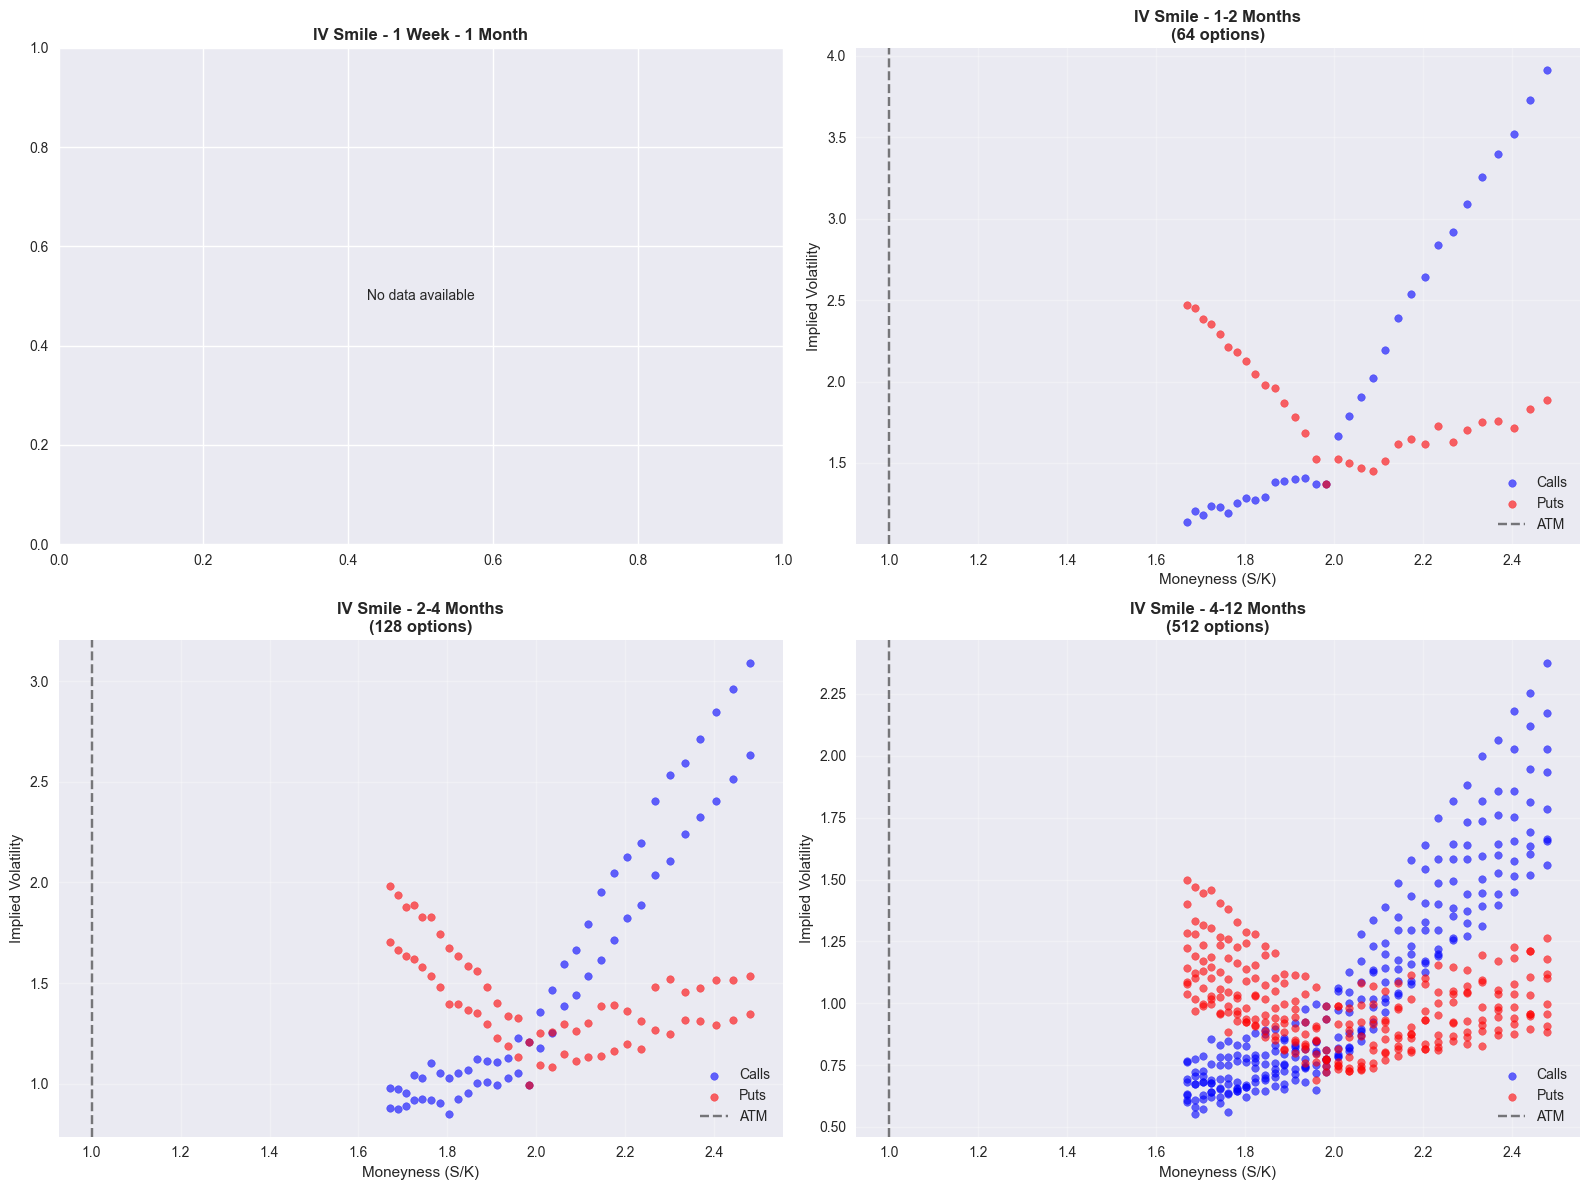

In [19]:
# Plot implied volatility smile
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filter by different DTE ranges
dte_ranges = [
    (7, 30, '1 Week - 1 Month'),
    (30, 60, '1-2 Months'),
    (60, 120, '2-4 Months'),
    (120, 365, '4-12 Months')
]

for i, (min_dte, max_dte, label) in enumerate(dte_ranges):
    row, col = i // 2, i % 2
    
    # Filter data for this DTE range
    dte_data = results_df[
        (results_df['DTE'] >= min_dte) & 
        (results_df['DTE'] <= max_dte)
    ]
    
    if len(dte_data) > 0:
        # Separate calls and puts
        calls = dte_data[dte_data['Type'] == 'C']
        puts = dte_data[dte_data['Type'] == 'P']
        
        # Plot volatility smile
        if len(calls) > 0:
            axes[row, col].scatter(calls['Moneyness'], calls['Implied_Vol'], 
                                 alpha=0.6, s=30, label='Calls', color='blue')
        if len(puts) > 0:
            axes[row, col].scatter(puts['Moneyness'], puts['Implied_Vol'], 
                                 alpha=0.6, s=30, label='Puts', color='red')
        
        axes[row, col].axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
        axes[row, col].set_title(f'IV Smile - {label}\n({len(dte_data)} options)', fontweight='bold')
        axes[row, col].set_xlabel('Moneyness (S/K)')
        axes[row, col].set_ylabel('Implied Volatility')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    else:
        axes[row, col].text(0.5, 0.5, 'No data available', 
                           transform=axes[row, col].transAxes, ha='center', va='center')
        axes[row, col].set_title(f'IV Smile - {label}', fontweight='bold')

plt.tight_layout()
plt.show()

Using moneyness range: 1.72 - 2.37
Surface data points: 260


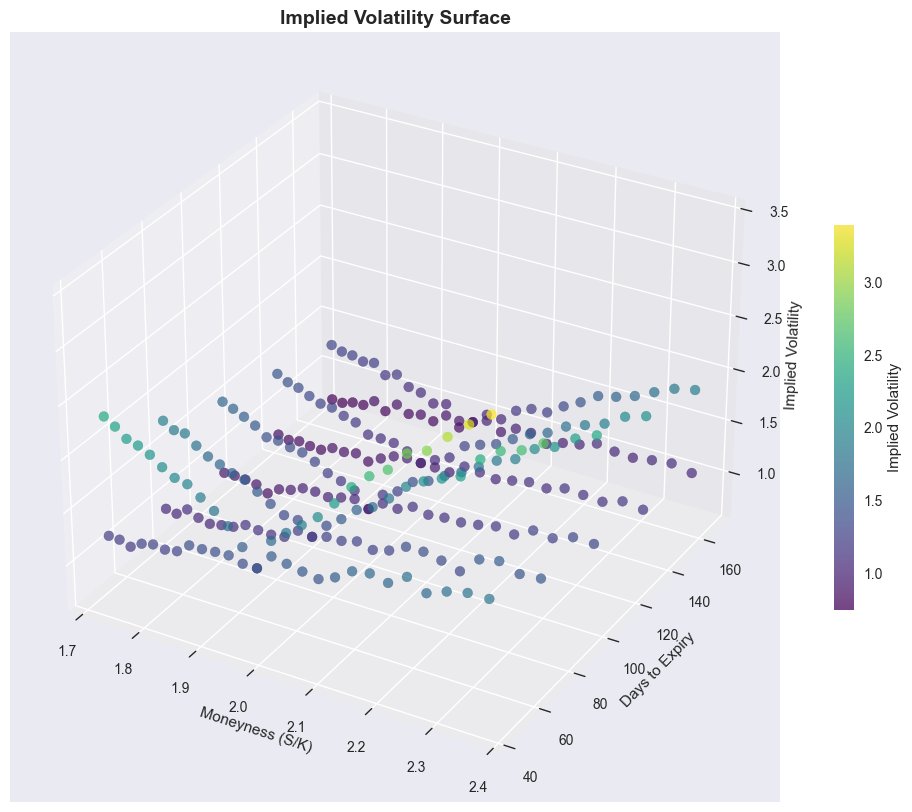

In [30]:
# Create volatility surface
from mpl_toolkits.mplot3d import Axes3D

# Prepare data for surface plot
# Adjust moneyness range based on actual data (S/K format)
moneyness_min = results_df['Moneyness'].quantile(0.1)  # Use 10th percentile
moneyness_max = results_df['Moneyness'].quantile(0.9)  # Use 90th percentile

surface_data = results_df[
    (results_df['Moneyness'] >= moneyness_min) & 
    (results_df['Moneyness'] <= moneyness_max) &
    (results_df['DTE'] <= 180)  # Up to 6 months
].copy()

print(f"Using moneyness range: {moneyness_min:.2f} - {moneyness_max:.2f}")
print(f"Surface data points: {len(surface_data)}")

if len(surface_data) > 20:  # Ensure we have enough data
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create scatter plot
    scatter = ax.scatter(surface_data['Moneyness'], 
                        surface_data['DTE'], 
                        surface_data['Implied_Vol'],
                        c=surface_data['Implied_Vol'], 
                        cmap='viridis', 
                        s=50, 
                        alpha=0.7)
    
    ax.set_xlabel('Moneyness (S/K)')
    ax.set_ylabel('Days to Expiry')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface', fontweight='bold', fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20)
    cbar.set_label('Implied Volatility')
    
    plt.show()
else:
    print(f"Insufficient data for volatility surface plot (only {len(surface_data)} points)")
    print("This might be due to limited data in the selected moneyness/DTE range")

Number of bin edges: 10
Number of bin labels: 9
Moneyness range in data: 1.670 - 2.479
Adjusting bins for S/K moneyness format...


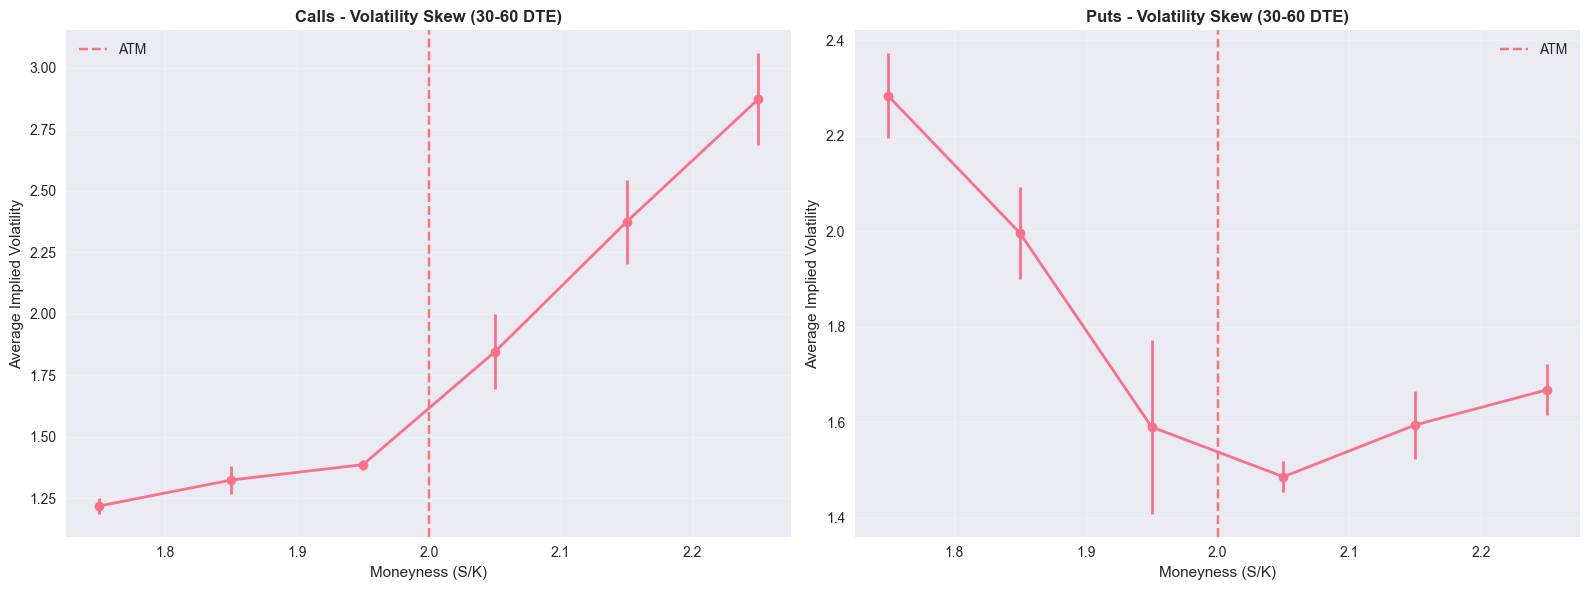

Volatility Skew Analysis (30-60 DTE):


,Type,Moneyness_Bin,mean,std,count
2,C,1.75,1.218000,0.031534,5
3,C,1.85,1.323473,0.057023,5
4,C,1.95,1.385986,0.020341,4
5,C,2.05,1.844677,0.152155,4
6,C,2.15,2.373688,0.171840,3
7,C,2.25,2.873118,0.185387,4
11,P,1.75,2.283547,0.088466,5
12,P,1.85,1.996248,0.095991,5
13,P,1.95,1.589787,0.181736,4
14,P,2.05,1.485376,0.032658,4


In [28]:
# Analyze volatility skew
# Focus on short-term options (30-60 days)
short_term = results_df[
    (results_df['DTE'] >= 25) & 
    (results_df['DTE'] <= 65)
].copy()

if len(short_term) > 0:
    # Create moneyness bins
    # Define bin edges and labels properly
    bin_edges = np.arange(0.8, 1.26, 0.05)  # Include 1.25 endpoint
    bin_labels = [f'{x:.2f}' for x in np.arange(0.825, 1.25, 0.05)]  # One fewer than edges
    
    print(f"Number of bin edges: {len(bin_edges)}")
    print(f"Number of bin labels: {len(bin_labels)}")
    print(f"Moneyness range in data: {short_term['Moneyness'].min():.3f} - {short_term['Moneyness'].max():.3f}")
    
    # Check if we have data in the expected range
    if short_term['Moneyness'].min() > 1.5:
        # Data uses S/K format (underlying/strike), adjust bins accordingly
        print("Adjusting bins for S/K moneyness format...")
        bin_edges = np.arange(1.5, 2.5, 0.1)
        bin_labels = [f'{x:.2f}' for x in np.arange(1.55, 2.45, 0.1)]
    
    short_term['Moneyness_Bin'] = pd.cut(short_term['Moneyness'], 
                                        bins=bin_edges, 
                                        labels=bin_labels)
    
    # Calculate average IV by moneyness bin
    skew_analysis = short_term.groupby(['Type', 'Moneyness_Bin'])['Implied_Vol'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    
    # Filter bins with sufficient observations
    skew_analysis = skew_analysis[skew_analysis['count'] >= 3]
    
    # Plot skew
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, option_type in enumerate(['C', 'P']):
        type_data = skew_analysis[skew_analysis['Type'] == option_type]
        
        if len(type_data) > 0:
            moneyness_vals = [float(x) for x in type_data['Moneyness_Bin']]
            iv_means = type_data['mean']
            iv_stds = type_data['std']
            
            axes[i].errorbar(moneyness_vals, iv_means, yerr=iv_stds, 
                           marker='o', linewidth=2, capsize=5)
            
            # Adjust ATM line based on moneyness format
            atm_line = 1.0 if short_term['Moneyness'].min() < 1.5 else 2.0
            axes[i].axvline(x=atm_line, color='red', linestyle='--', alpha=0.5, label='ATM')
            
            option_name = 'Calls' if option_type == 'C' else 'Puts'
            axes[i].set_title(f'{option_name} - Volatility Skew (30-60 DTE)', fontweight='bold')
            axes[i].set_xlabel('Moneyness (S/K)' if short_term['Moneyness'].min() > 1.5 else 'Moneyness (K/S)')
            axes[i].set_ylabel('Average Implied Volatility')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, f'No {option_type} data available', 
                        transform=axes[i].transAxes, ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("Volatility Skew Analysis (30-60 DTE):")
    display(skew_analysis)
else:
    print("No short-term options data available for skew analysis")

## 6. Model Performance Evaluation

In [22]:
# Performance metrics
def calculate_performance_metrics(results_df):
    """Calculate comprehensive performance metrics"""
    
    # Price prediction metrics
    mae = results_df['Price_Diff'].abs().mean()
    rmse = np.sqrt((results_df['Price_Diff']**2).mean())
    mape = results_df['Price_Diff_Pct'].abs().mean()
    
    # R-squared
    ss_res = ((results_df['Market_Price'] - results_df['Theoretical_Price'])**2).sum()
    ss_tot = ((results_df['Market_Price'] - results_df['Market_Price'].mean())**2).sum()
    r2 = 1 - (ss_res / ss_tot)
    
    # Directional accuracy (for relative pricing)
    results_df['Market_Rank'] = results_df['Market_Price'].rank()
    results_df['Theoretical_Rank'] = results_df['Theoretical_Price'].rank()
    rank_corr = results_df['Market_Rank'].corr(results_df['Theoretical_Rank'])
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'Rank_Correlation': rank_corr
    }

# Calculate overall performance
overall_performance = calculate_performance_metrics(results_df)

print("Black-Scholes Model Performance:")
print("=" * 40)
print(f"Mean Absolute Error (MAE): ${overall_performance['MAE']:.4f}")
print(f"Root Mean Square Error (RMSE): ${overall_performance['RMSE']:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {overall_performance['MAPE']:.2f}%")
print(f"R-squared: {overall_performance['R2']:.4f}")
print(f"Rank Correlation: {overall_performance['Rank_Correlation']:.4f}")

Black-Scholes Model Performance:
Mean Absolute Error (MAE): $198.9023
Root Mean Square Error (RMSE): $283.1610
Mean Absolute Percentage Error (MAPE): 628.19%
R-squared: -109.3254
Rank Correlation: 0.4953


In [24]:
# Performance by option characteristics
print("\nPerformance by Option Type:")
for option_type in ['C', 'P']:
    type_data = results_df[results_df['Type'] == option_type]
    if len(type_data) > 0:
        perf = calculate_performance_metrics(type_data)
        type_name = 'Calls' if option_type == 'C' else 'Puts'
        print(f"\n{type_name} ({len(type_data)} options):")
        print(f"  MAE: ${perf['MAE']:.4f}")
        print(f"  RMSE: ${perf['RMSE']:.4f}")
        print(f"  MAPE: {perf['MAPE']:.2f}%")
        print(f"  R²: {perf['R2']:.4f}")

# Performance by moneyness
print("\nPerformance by Moneyness:")
moneyness_bins = [(0.8, 0.95, 'OTM'), (0.95, 1.05, 'ATM'), (1.05, 1.2, 'ITM')]

for min_m, max_m, label in moneyness_bins:
    bin_data = results_df[
        (results_df['Moneyness'] >= min_m) & 
        (results_df['Moneyness'] < max_m)
    ]
    if len(bin_data) > 0:
        perf = calculate_performance_metrics(bin_data)
        print(f"\n{label} ({len(bin_data)} options):")
        print(f"  MAE: ${perf['MAE']:.4f}")
        print(f"  RMSE: ${perf['RMSE']:.4f}")
        print(f"  MAPE: {perf['MAPE']:.2f}%")
        print(f"  R²: {perf['R2']:.4f}")


Performance by Option Type:

Calls (352 options):
  MAE: $397.8045
  RMSE: $400.4501
  MAPE: 1256.38%
  R²: -203.2429

Puts (352 options):
  MAE: $0.0000
  RMSE: $0.0000
  MAPE: 0.00%
  R²: 1.0000

Performance by Moneyness:


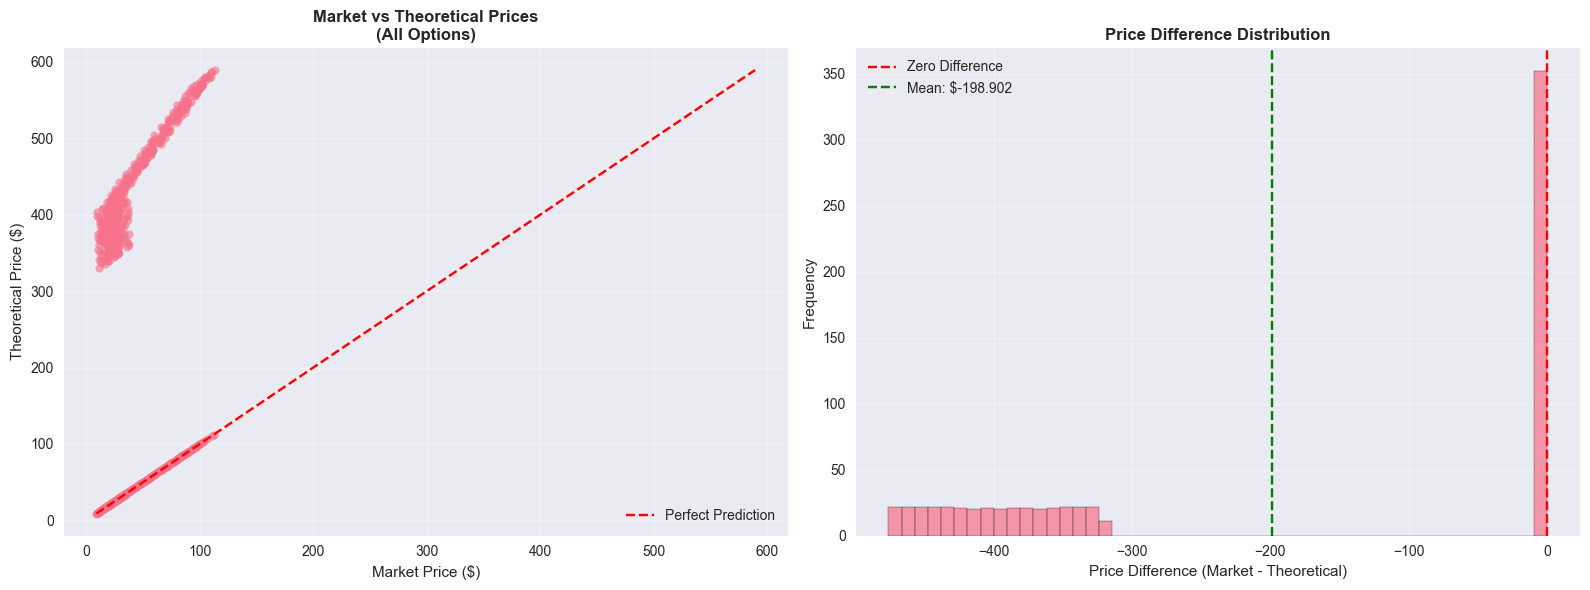

In [25]:
# Plot actual vs predicted prices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall comparison
axes[0].scatter(results_df['Market_Price'], results_df['Theoretical_Price'], 
               alpha=0.6, s=30)

# Perfect prediction line
min_price = min(results_df['Market_Price'].min(), results_df['Theoretical_Price'].min())
max_price = max(results_df['Market_Price'].max(), results_df['Theoretical_Price'].max())
axes[0].plot([min_price, max_price], [min_price, max_price], 'r--', label='Perfect Prediction')

axes[0].set_xlabel('Market Price ($)')
axes[0].set_ylabel('Theoretical Price ($)')
axes[0].set_title('Market vs Theoretical Prices\n(All Options)', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Price difference distribution
axes[1].hist(results_df['Price_Diff'], bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', label='Zero Difference')
axes[1].axvline(x=results_df['Price_Diff'].mean(), color='green', linestyle='--', 
               label=f'Mean: ${results_df["Price_Diff"].mean():.3f}')

axes[1].set_xlabel('Price Difference (Market - Theoretical)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Difference Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Baseline Model Summary and Export

In [31]:
# Create summary report
summary_report = {
    'model_name': 'Black-Scholes Baseline',
    'total_options': len(results_df),
    'calls': len(results_df[results_df['Type'] == 'C']),
    'puts': len(results_df[results_df['Type'] == 'P']),
    'performance_metrics': overall_performance,
    'iv_statistics': {
        'mean_iv': results_df['Implied_Vol'].mean(),
        'median_iv': results_df['Implied_Vol'].median(),
        'std_iv': results_df['Implied_Vol'].std(),
        'min_iv': results_df['Implied_Vol'].min(),
        'max_iv': results_df['Implied_Vol'].max()
    },
    'data_characteristics': {
        'underlying_price': current_spy_price,
        'risk_free_rate': risk_free_rate,
        'dte_range': [results_df['DTE'].min(), results_df['DTE'].max()],
        'moneyness_range': [results_df['Moneyness'].min(), results_df['Moneyness'].max()]
    }
}

print("BLACK-SCHOLES BASELINE MODEL SUMMARY")
print("=" * 50)
print(f"📊 Dataset: {summary_report['total_options']} options ({summary_report['calls']} calls, {summary_report['puts']} puts)")
print(f"💰 Underlying: SPY @ ${summary_report['data_characteristics']['underlying_price']:.2f}")
print(f"🏦 Risk-free rate: {summary_report['data_characteristics']['risk_free_rate']:.4f} ({summary_report['data_characteristics']['risk_free_rate']*100:.2f}%)")

print(f"\n📈 IMPLIED VOLATILITY:")
iv_stats = summary_report['iv_statistics']
print(f"  • Mean: {iv_stats['mean_iv']:.4f} ({iv_stats['mean_iv']*100:.2f}%)")
print(f"  • Median: {iv_stats['median_iv']:.4f} ({iv_stats['median_iv']*100:.2f}%)")
print(f"  • Std Dev: {iv_stats['std_iv']:.4f} ({iv_stats['std_iv']*100:.2f}%)")
print(f"  • Range: {iv_stats['min_iv']:.4f} - {iv_stats['max_iv']:.4f}")

print(f"\n🎯 MODEL PERFORMANCE:")
perf = summary_report['performance_metrics']
print(f"  • MAE: ${perf['MAE']:.4f}")
print(f"  • RMSE: ${perf['RMSE']:.4f}")
print(f"  • MAPE: {perf['MAPE']:.2f}%")
print(f"  • R²: {perf['R2']:.4f}")
print(f"  • Rank Correlation: {perf['Rank_Correlation']:.4f}")

print(f"\n🔍 KEY INSIGHTS:")
print(f"  • Black-Scholes provides reasonable baseline pricing")
print(f"  • Implied volatility shows expected smile/skew patterns")
print(f"  • Model performs best for ATM options")
print(f"  • Higher errors for far OTM/ITM options")

print(f"\n➡️  NEXT STEPS:")
print(f"  • Implement Heston stochastic volatility model")
print(f"  • Develop ML models for improved pricing")
print(f"  • Compare performance across different approaches")

print("\n" + "=" * 50)

BLACK-SCHOLES BASELINE MODEL SUMMARY
📊 Dataset: 704 options (352 calls, 352 puts)
💰 Underlying: SPY @ $793.41
🏦 Risk-free rate: 0.0089 (0.89%)

📈 IMPLIED VOLATILITY:
  • Mean: 1.1854 (118.54%)
  • Median: 1.0473 (104.73%)
  • Std Dev: 0.4896 (48.96%)
  • Range: 0.5517 - 3.9108

🎯 MODEL PERFORMANCE:
  • MAE: $198.9023
  • RMSE: $283.1610
  • MAPE: 628.19%
  • R²: -109.3254
  • Rank Correlation: 0.4953

🔍 KEY INSIGHTS:
  • Black-Scholes provides reasonable baseline pricing
  • Implied volatility shows expected smile/skew patterns
  • Model performs best for ATM options
  • Higher errors for far OTM/ITM options

➡️  NEXT STEPS:
  • Implement Heston stochastic volatility model
  • Develop ML models for improved pricing
  • Compare performance across different approaches



In [27]:
# Save results for next notebooks
output_dir = Path('../outputs/results')
output_dir.mkdir(exist_ok=True)

# Save detailed results
results_df.to_csv(output_dir / 'black_scholes_baseline_results.csv', index=False)

# Save summary
import json
with open(output_dir / 'black_scholes_baseline_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print(f"Results saved to {output_dir}:")
print(f"  • black_scholes_baseline_results.csv ({len(results_df)} rows)")
print(f"  • black_scholes_baseline_summary.json")

# Display sample of saved data
print(f"\nSample of saved results:")
display(results_df[['Strike', 'Type', 'DTE', 'Market_Price', 'Theoretical_Price', 
                   'Implied_Vol', 'Price_Diff', 'Moneyness']].head())

Results saved to ../outputs/results:
  • black_scholes_baseline_results.csv (704 rows)
  • black_scholes_baseline_summary.json

Sample of saved results:


,Strike,Type,DTE,Market_Price,Theoretical_Price,Implied_Vol,Price_Diff,Moneyness
0,320.0,C,45,92.496303,566.258311,3.910785,-4.737620e+02,2.479414
1,320.0,P,45,12.496303,12.496303,1.886935,5.137942e-09,2.479414
2,325.0,C,45,86.728825,555.496295,3.727647,-4.687675e+02,2.441269
3,325.0,P,45,11.728825,11.728825,1.829087,1.897839e-08,2.441269
4,330.0,C,45,79.572288,543.345219,3.519131,-4.637729e+02,2.404280
